In [7]:
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
import statsmodels.api as sm

In [8]:
%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
data_dir = Path('../data')

In [105]:
def get_asset_returns(start=2010, end=2017, outliers=1):
    with pd.HDFStore('assets.h5') as store:
        sp500 = store.get('sp500s')
        asset_prices = store.get('zip_quandl').filter(sp500)
        asset_prices = asset_prices.loc[str(start):str(end)]
        outliers = asset_prices.pct_change().abs().gt(outliers).any()
        asset_prices = asset_prices.loc[:, outliers[~outliers].index]
        return asset_prices.pct_change().dropna(how='all').dropna(how='all', axis=1)
#         asset_prices = asset_prices.dropna(thresh=int(len(asset_prices) * .9), axis=1).dropna(how='all'        

In [109]:
with pd.HDFStore('assets.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: assets.h5
/securities                    frame        (shape->[4817,8])   
/sp500                         frame        (shape->[37711,5])  
/sp500_constituents            frame        (shape->[1,8])      
/sp500q                        series       (shape->[1])        
/sp500s                        series       (shape->[1])        
/zip_quandl                    frame        (shape->[4173,3196])


In [128]:
def plot_returns(ret):
    with pd.HDFStore('assets.h5') as store:
        benchmark_ret = store['sp500'].Close.pct_change()
        benchmark_ret.index = benchmark_ret.index.tz_localize('UTC')   
    for k, v in ret.items():
        v = v.sum(axis=1).to_frame(k)
        v['sp500'] = benchmark_ret
#         print(v)
        v.add(1).fillna(1).cumprod().sub(1).plot(title=k, lw=2)
        plt.show()

In [129]:
def momentum(start=2010, end=2017, outliers=1, ma1=5, ma2=50, hp_long=5, hp_short=5, lower=.00, upper=.95, short=False):
    asset_returns = get_asset_returns(start, end, outliers)
    start_date = asset_returns.index[ma2]
    print('# Stocks:', asset_returns.shape, '\n')

    mav, entry, weights, returns = {}, {}, {}, {}
    # for ma in [ma1, ma2]:
    #     mav[ma] = asset_returns.add(1).rolling(ma).apply(rolling_ret, raw=True)
    #     mav[ma] = mav[ma].dropna(how='all').loc[start_date:]
    # momentum = mav[ma1].sub(mav[ma2])
    # # quantiles = momentum.quantile(q=[lower, upper], axis=1).T
    with pd.HDFStore('test.h5') as store:
        # store.put('quantiles', quantiles)
        # store.put('momentum', momentum)
        momentum = store.get('momentum')
        quantiles = store.get('quantiles')

    strategies = [{'name': 'long', 'rule': 'gt', 'q': upper, 'mult': 1, 'hp': hp_long}]
    if short:
        strategies.append({'name': 'short', 'rule': 'lt', 'q': lower, 'mult': -1, 'hp': hp_short})
    for s in strategies:
        entry[s['name']] = getattr(momentum, s['rule'])(quantiles[s['q']], axis=0).astype(int)
        weights[s['name']] = entry[s['name']].div(entry[s['name']].sum(axis=1), axis=0)
        weights[s['name']] = weights[s['name']].fillna(method='ffill', limit=s['hp']).fillna(0).mul(s['mult'])
        returns[s['name']] = weights[s['name']].shift().mul(asset_returns.loc[start_date:])

    # print(returns['long'])
    returns['pf'] = returns['long'].copy()
    if short:
        returns['pf'] += returns['short']
    plot_returns(returns)
    # print(returns['pf'])
    return {k: v.sum(axis=1).add(1).fillna(1).prod() - 1 for k, v in returns.items()}

# Stocks: (2084, 489) 



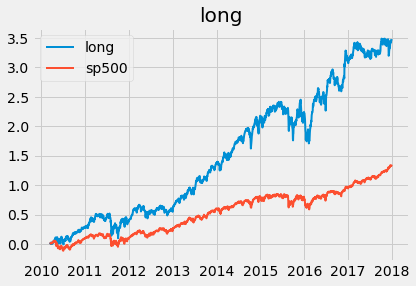

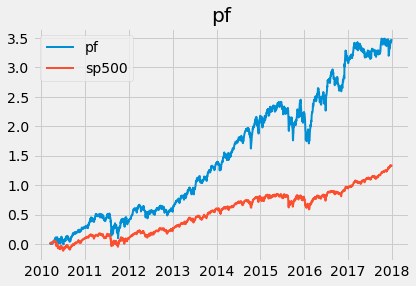

In [130]:
returns = momentum()

#### Eval Returns

In [2]:
with pd.HDFStore('momentum.h5') as store:
    returns = store.get('returns')
    top_returns = store.get('returns_top')

In [3]:
returns = returns.reset_index().rename(columns={'index':'date'})

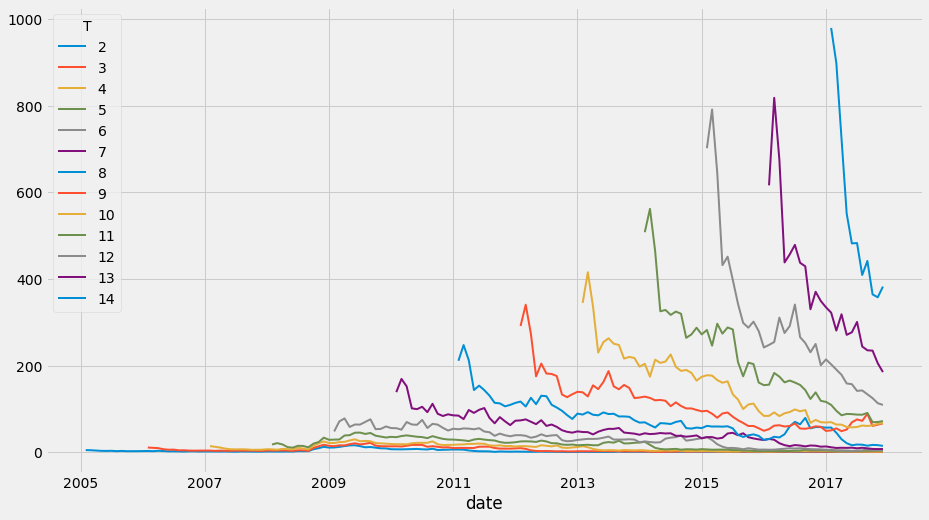

In [13]:
returns.groupby(['date', 'T']).alpha.max().unstack().plot(figsize=(14, 8), lw=2);

In [157]:
outlier = returns.alpha.quantile(.95)
returns = returns[returns.alpha < outlier]

In [158]:
dcols = ['ma1', 'ma2', 'lower', 'upper', 'hp_short', 'hp_long', 'srt','T']

X = sm.add_constant(pd.get_dummies(returns.select_dtypes(exclude=float).astype(str)))
model = sm.OLS(returns.alpha, X)
results = model.fit()

In [159]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  alpha   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                 4.035e+04
Date:                Sun, 24 Jun 2018   Prob (F-statistic):               0.00
Time:                        12:29:27   Log-Likelihood:            -3.4061e+06
No. Observations:             1175720   AIC:                         6.812e+06
Df Residuals:                 1175680   BIC:                         6.813e+06
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.084e+10   3.08e+10     -0.352      0.725   -7.13e+10    4.96e+10
ma1_10      -1.002e+09   1.15e+09     -0.875      0.382   -3.25e+09    1.24e+09
ma1_15      -1.002e+09   1.15e+09     -0.875      0.382   -3.25e+09    1.24e+09
ma1_20      -1.002e+09   1.15e+09     -0.875      0.382   -3.25e+09    1.24e+09
ma1_25      -1.002e+09   1.15e+09     -0.875      0.382   -3.25e+09    1.24e+09
ma1_5       -1.002e+09   1.15e+09     -0.875      0.382   -3.25e+09    1.24e+09
ma2_100       1.02e+09   3.07e+09      0.333      0.739   -4.99e+09    7.03e+09
ma2_125       1.02e+09   3.07e+09      0.333      0.739   -4.99e+09    7.03e+09
ma2_150       1.02e+09   3.07e+09      0.333      0.739   -4.99e+09    7.03e+09
ma2_175       1.02e+09   3.07e+09      0.333      0.739   -4.99e+09    7.03e+09
ma2_200       1.02e+09   3.07e+09      0.333      0.739   -4.99e+09    7.03e+09
ma2_50        1.02e+09   3.07e+09      0.333      0.739   -4.99e+09    7.03e+09
ma2_75        1.02e+09   3.07e+09      0.333      0.739   -4.99e+09    7.03e+09
lower_0     -6.257e+09   2.78e+10     -0.225      0.822   -6.08e+10    4.83e+10
lower_10    -5.905e+09    8.9e+10     -0.066      0.947    -1.8e+11    1.69e+11
upper_90    -2.685e+09   1.07e+10     -0.251      0.802   -2.36e+10    1.83e+10
upper_95    -2.685e+09   1.07e+10     -0.251      0.802   -2.36e+10    1.83e+10
upper_97    -2.685e+09   1.07e+10     -0.251      0.802   -2.36e+10    1.83e+10
upper_99    -2.685e+09   1.07e+10     -0.251      0.802   -2.36e+10    1.83e+10
hp_short_0   6.106e+09      4e+10      0.153      0.879   -7.23e+10    8.45e+10
hp_short_10  4.983e+10   9.87e+10      0.505      0.614   -1.44e+11    2.43e+11
hp_long_1    1.273e+10   2.47e+10      0.515      0.607   -3.57e+10    6.12e+10
hp_long_10   1.273e+10   2.47e+10      0.515      0.607   -3.57e+10    6.12e+10
hp_long_3    1.273e+10   2.47e+10      0.515      0.607   -3.57e+10    6.12e+10
hp_long_5    1.273e+10   2.47e+10      0.515      0.607   -3.57e+10    6.12e+10
srt_0       -7.139e+09   4.25e+10     -0.168      0.866   -9.04e+10    7.61e+10
srt_1       -5.122e+10   7.76e+10     -0.660      0.509   -2.03e+11    1.01e+11
T_10         8.068e+09   3.47e+10      0.233      0.816   -5.99e+10     7.6e+10
T_11         8.068e+09   3.47e+10      0.233      0.816   -5.99e+10     7.6e+10
T_12         8.068e+09   3.47e+10      0.233      0.816   -5.99e+10     7.6e+10
T_13         8.068e+09   3.47e+10      0.233      0.816   -5.99e+10     7.6e+10
T_14         8.068e+09   3.47e+10      0.233      0.816   -5.99e+10     7.6e+10
T_2          8.068e+09   3.47e+10      0.233      0.816   -5.99e+10     7.6e+10
T_3          8.068e+09   3.47e+10      0.233      0.816   -5.99e+10     7.6e+10
T_4          8.068e+09   3.47e+10      0.233      0.816   -5.99e+10     7.6e+10
T_5          8.068e+09   3.47e+10      0.23

### Check asset returns

In [2]:
with pd.HDFStore('assets.h5') as store:
    sp500 = store.get('sp500s')
    asset_prices = store.get('zip_quandl').filter(sp500)
    asset_prices = asset_prices.loc['2002':'2017']
#     outliers = asset_prices.pct_change().abs().gt(outliers).any()
#     asset_prices = asset_prices.loc[:, outliers[~outliers].index]
asset_returns = asset_prices.pct_change().dropna(how='all').dropna(how='all', axis=1)

In [3]:
asset_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4172 entries, 2002-01-03 to 2017-12-29
Freq: B
Columns: 498 entries, A to ZTS
dtypes: float64(498)
memory usage: 15.9 MB


In [5]:
print((asset_returns>1).sum().value_counts())

0    485
1     13
dtype: int64


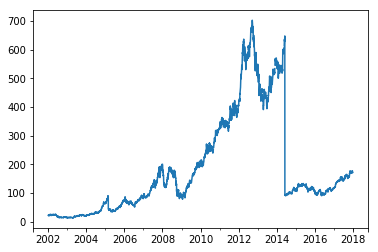

In [7]:
asset_prices['AAPL'].plot();